In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scripts.data_loader import load_caravan
from scripts.metrics import evaluate_model

In [37]:
train, test, X, y, TARGET = load_caravan(data_dir="./data")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

In [32]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint, uniform

gb = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 300, 50),  # Number of boosting stages
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Learning rate shrinks the contribution of each tree
    'max_depth': np.arange(3, 15, 2),  # Maximum depth of the individual trees
    'min_samples_split': np.arange(2, 20, 2),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': np.arange(1, 20, 2),  # Minimum number of samples required to be at a leaf node
    'subsample': np.linspace(0.6, 1.0, 5),  # Fraction of samples used for fitting individual base learners
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when looking for the best split
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=50,                    # small but effective search
    scoring='average_precision',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gb_search.fit(X_train, y_train)
print("Best GB params:", gb_search.best_params_)
print("Best CV PR-AUC:", round(gb_search.best_score_, 4))

gb_best = gb_search.best_estimator_


proba_val = gb_best.predict_proba(X_val)[:, 1]
preds_val = (proba_val >= 0.5).astype(int)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/zulekhanoor/venvs/jupy-intel/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zulekhanoor/venvs/jupy-intel/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zulekhanoor/venvs/jupy-intel/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/zulekhanoor/venvs/jupy-intel/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
  

Best GB params: {'subsample': np.float64(0.9), 'n_estimators': np.int64(200), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(1), 'max_features': 'sqrt', 'max_depth': np.int64(3), 'learning_rate': np.float64(0.07444444444444444)}
Best CV PR-AUC: 0.1656


In [33]:

results = evaluate_model("Gradient Boosting (tuned) ", y_val, proba_val)


=== Gradient Boosting (tuned)  ===
ROC-AUC: 0.7729 | PR-AUC: 0.2102
Best-F1 threshold: 0.109
At best-F1: Precision=0.217, Recall=0.443, F1=0.291
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1095
           1       0.22      0.44      0.29        70

    accuracy                           0.87      1165
   macro avg       0.59      0.67      0.61      1165
weighted avg       0.92      0.87      0.89      1165



In [36]:
X_test = test.copy()
best_thr = 0.109

# If our model requires probabilities (e.g., for setting a threshold), we can use predict_proba
test_probabilities = gb_best.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

test_pred = (test_probabilities >= best_thr).astype(int)

# 5) Report count and percentage
num_pred = int(test_pred.sum())
total = len(test_pred)
pct = 100.0 * num_pred / total

print(f"Number of customers predicted to be interested: {num_pred}")
print(f"Percentage of customers predicted to be interested: {pct:.2f}%")

Number of customers predicted to be interested: 491
Percentage of customers predicted to be interested: 12.28%


Top 10 Features Influencing Decisions:
                       Feature  Importance
46   Contribution car policies    0.112964
58  Contribution fire policies    0.062469
60  Contribution boat policies    0.041433
81          # of boat policies    0.038259
0             Customer Subtype    0.031008
75        # of life insurances    0.030996
22           Skilled labourers    0.029007
41              Average income    0.027814
39           Income 75-122.000    0.027739
17       Lower level education    0.026843


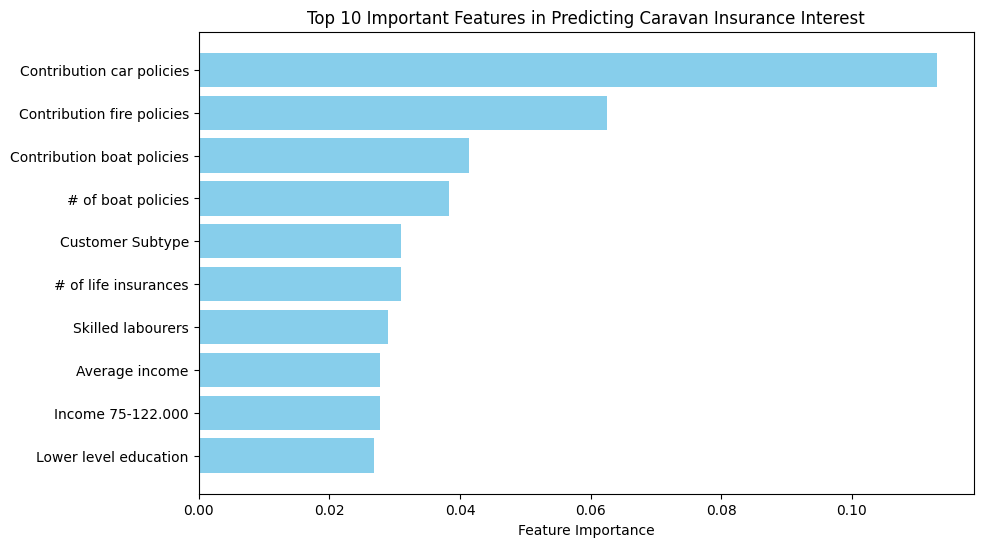

In [35]:
# Extract feature importances
feature_importances = gb_best.feature_importances_
features = test.columns


# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
top_features = importance_df.head(10)
print("Top 10 Features Influencing Decisions:")
print(top_features)

# Plotting the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features in Predicting Caravan Insurance Interest')
plt.show()